## Export model so I can load it in JavaScript

>**Note**<br><br>
This is not a guide on how to transfer Pytorch models to Tensorflow.js models. 
<br><br>
>I use nobuco __No Bullshit Converter__ [GitHub](https://github.com/AlexanderLutsenko/nobuco) made by Alexander Lutsenko.

In [1]:
# model:
import os
import numpy as np
import torch
from torchsummary import summary
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import torch.nn as nn 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt 
%matplotlib inline

# Path directory
dir_path = "dataset/data-splited 3"

# Data augmentation transformations (only train set)
train_transform = v2.Compose([
    v2.ToImage(),  # Convert to tensor
    #v2.RandomPerspective(distortion_scale=0.6, p=1.0),
    v2.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),  # Bicubic Interpolation for Better Quality
    v2.RandomRotation(20),   # Random rotation
    #v2.RandomAffine(degrees=0, translate=(0.2, 0.1), shear=20),
    #v2.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    # Add more transformations if needed
    v2.ToDtype(torch.float32, scale=True),
    # Normalize using Imagenet pretrianed model with its own mean and std is recommended.
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

# Data augmentation transformations for val and test sets
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224), interpolation=InterpolationMode.BICUBIC), 
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

# Load dataset
train_set = ImageFolder(os.path.join(dir_path, "train"), transform=train_transform)
val_set = ImageFolder(os.path.join(dir_path, "val"), transform=transform)
test_set = ImageFolder(os.path.join(dir_path, "test"), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)




class NeuralNetwork(nn.Module):
    def __init__(self, num_classes=len(train_set.classes)):
        super(NeuralNetwork, self).__init__()
        # Where we define all the parts of the model
        self.base_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # Code the of the base model
        #for param in self.base_model.parameters():
        #    param.requires_grad = False  # Freeze all layers initially
        self.fine_tune_at = 165

        # Iterate through parameters, not layers directly
        for i, param in enumerate(self.base_model.parameters()):
            if i >= self.fine_tune_at: 
                param.requires_grad = True  # Unfreeze parameters
            else:
                param.requires_grad = False

      
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # More flexible than GlobalAveragePooling
            nn.Flatten(),
            nn.Linear(960, 1024),  # Adjust input features
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1) 
        )
        
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        
        return output
    
    
model = NeuralNetwork(len(train_set.classes))

summary(model.cuda(), (3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 960, 1, 1]           --
├─MobileNetV3: 1                              []                        --
|    └─Sequential: 2-1                        [-1, 960, 7, 7]           --
├─Sequential: 1                               []                        --
|    └─Sequential: 2-2                        [-1, 960, 7, 7]           (recursive)
├─MobileNetV3: 1                              []                        --
|    |    └─Conv2dNormActivation: 3-1         [-1, 16, 112, 112]        (464)
├─Sequential: 1                               []                        --
|    |    └─Conv2dNormActivation: 3-2         [-1, 16, 112, 112]        (recursive)
├─MobileNetV3: 1                              []                        --
|    |    └─InvertedResidual: 3-3             [-1, 16, 112, 112]        (464)
├─Sequential: 1                               []                       

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 960, 1, 1]           --
├─MobileNetV3: 1                              []                        --
|    └─Sequential: 2-1                        [-1, 960, 7, 7]           --
├─Sequential: 1                               []                        --
|    └─Sequential: 2-2                        [-1, 960, 7, 7]           (recursive)
├─MobileNetV3: 1                              []                        --
|    |    └─Conv2dNormActivation: 3-1         [-1, 16, 112, 112]        (464)
├─Sequential: 1                               []                        --
|    |    └─Conv2dNormActivation: 3-2         [-1, 16, 112, 112]        (recursive)
├─MobileNetV3: 1                              []                        --
|    |    └─InvertedResidual: 3-3             [-1, 16, 112, 112]        (464)
├─Sequential: 1                               []                       

In [2]:
# 1. Load your trained PyTorch model
saved_model = torch.load('pytorch-model-CPU.pt')

summary(saved_model, (3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 960, 1, 1]           --
├─MobileNetV3: 1                              []                        --
|    └─Sequential: 2-1                        [-1, 960, 7, 7]           --
├─Sequential: 1                               []                        --
|    └─Sequential: 2-2                        [-1, 960, 7, 7]           (recursive)
├─MobileNetV3: 1                              []                        --
|    |    └─Conv2dNormActivation: 3-1         [-1, 16, 112, 112]        (464)
├─Sequential: 1                               []                        --
|    |    └─Conv2dNormActivation: 3-2         [-1, 16, 112, 112]        (recursive)
├─MobileNetV3: 1                              []                        --
|    |    └─InvertedResidual: 3-3             [-1, 16, 112, 112]        (464)
├─Sequential: 1                               []                       

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 960, 1, 1]           --
├─MobileNetV3: 1                              []                        --
|    └─Sequential: 2-1                        [-1, 960, 7, 7]           --
├─Sequential: 1                               []                        --
|    └─Sequential: 2-2                        [-1, 960, 7, 7]           (recursive)
├─MobileNetV3: 1                              []                        --
|    |    └─Conv2dNormActivation: 3-1         [-1, 16, 112, 112]        (464)
├─Sequential: 1                               []                        --
|    |    └─Conv2dNormActivation: 3-2         [-1, 16, 112, 112]        (recursive)
├─MobileNetV3: 1                              []                        --
|    |    └─InvertedResidual: 3-3             [-1, 16, 112, 112]        (464)
├─Sequential: 1                               []                       

In [4]:
import torch

def resolve_inplace_warning(model):
    """Iterates through model modules to replace in-place operations"""
    for name, module in model.named_modules():
        if hasattr(module, 'forward'):  # Check if it's a module with a forward pass
            new_module = resolve_inplace_module(module) 
            setattr(model, name, new_module) 
    return model

def resolve_inplace_module(module):
    """Replaces in-place operations with out-of-place versions in a module"""
    # You'll need to customize the logic here based on the specific
    # in-place operations detected in your model.

    # Example: Assuming an in-place ReLU
    if isinstance(module, torch.nn.ReLU):
        return torch.nn.ReLU(inplace=False) 

    # Example: Common in-place operation replacement pattern.
    elif hasattr(module, 'inplace'): 
        new_module = type(module)(**module.__dict__) # Reconstruct the module
        new_module.inplace = False # Disable in-place operations
        return new_module

    else:
       return module  # No changes needed

my_pytorch_model = resolve_inplace_warning(saved_model) 

TypeError: Hardswish.__init__() got an unexpected keyword argument 'training'

In [3]:
# Import Nobuco dependencies
from nobuco import pytorch_to_keras, ChannelOrder

In [4]:
saved_model.to("cpu")

NeuralNetwork(
  (base_model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActi

# nobuco is not working correctly for now  

In [16]:
import nobuco
from nobuco import ChannelOrder, ChannelOrderingStrategy
from nobuco.layers.weight import WeightLayer

In [17]:
# Set the model to evaluation mode
saved_model.eval()

# Input_tensor = torch.randn(1, 224, 224, 3)
input_tensor = torch.randn(1, 3, 224, 224).to("cpu")

In [20]:
keras_model = keras_model = nobuco.pytorch_to_keras(saved_model, [input_tensor], inputs_channel_order=ChannelOrder.TENSORFLOW)

c:\Users\louis\anaconda3\envs\nobuco\Lib\site-packages\nobuco\converters\validation.py:55: RuntimeWarning: [<class 'torchvision.ops.misc.Conv2dNormActivation'>|NeuralNetwork->Sequential->Sequential->InvertedResidual->Sequential] conversion procedure might be incorrect: max. discrepancy for output #0 is 0.00014 (0.000%)
  warnings.warn(warn_string, category=RuntimeWarning)
c:\Users\louis\anaconda3\envs\nobuco\Lib\site-packages\nobuco\converters\validation.py:55: RuntimeWarning: [<class 'torch.nn.modules.container.Sequential'>|NeuralNetwork->Sequential->Sequential->InvertedResidual] conversion procedure might be incorrect: max. discrepancy for output #0 is 0.00013 (0.000%)
  warnings.warn(warn_string, category=RuntimeWarning)
c:\Users\louis\anaconda3\envs\nobuco\Lib\site-packages\nobuco\converters\validation.py:55: RuntimeWarning: [<class 'torchvision.models.mobilenetv3.InvertedResidual'>|NeuralNetwork->Sequential->Sequential] conversion procedure might be incorrect: max. discrepancy for

Legend:
    Green — conversion successful
    Yellow — conversion imprecise
    Red — conversion failed
    Red — no converter found
    Bold — conversion applied directly
    * — subgraph reused
    Tensor — this output is not dependent on any of subgraph's input tensors
    Tensor — this input is a parameter / constant
    Tensor — this tensor is useless

NeuralNetwork[__main__](float32_0<1,3,224,224>) -> float32_361<1,5>
 │  Sequential[torch.nn.modules.container](float32_0<1,3,224,224>) -> float32_347<1,960,1,1>
 │   │   (!) Max diff 0.00055 (0.021%)  
 │   │   I  File "C:\Users\louis\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\container.py", line 217 
 │   │   D  File "C:/Users/louis/AppData/Roaming/Python/Python311/site-packages/torch/nn/modules/container.py", line 43  
 │   │  Sequential[torch.nn.modules.container](float32_0<1,3,224,224>) -> float32_346<1,960,7,7>
 │   │   │  Conv2dNormActivation[torchvision.ops.misc](float32_0<1,3,224,224>) -> float32_5<1,16,

In [18]:
keras_model = nobuco.pytorch_to_keras(
    saved_model,
    args=[input_tensor], kwargs=None,
    inputs_channel_order=ChannelOrder.TENSORFLOW,
    outputs_channel_order=ChannelOrder.TENSORFLOW
)


c:\Users\louis\anaconda3\envs\nobuco\Lib\site-packages\nobuco\converters\validation.py:55: RuntimeWarning: [<class 'torchvision.ops.misc.Conv2dNormActivation'>|NeuralNetwork->Sequential->Sequential->InvertedResidual->Sequential] conversion procedure might be incorrect: max. discrepancy for output #0 is 0.00014 (0.000%)
  warnings.warn(warn_string, category=RuntimeWarning)
c:\Users\louis\anaconda3\envs\nobuco\Lib\site-packages\nobuco\converters\validation.py:55: RuntimeWarning: [<class 'torch.nn.modules.container.Sequential'>|NeuralNetwork->Sequential->Sequential->InvertedResidual] conversion procedure might be incorrect: max. discrepancy for output #0 is 0.00013 (0.000%)
  warnings.warn(warn_string, category=RuntimeWarning)
c:\Users\louis\anaconda3\envs\nobuco\Lib\site-packages\nobuco\converters\validation.py:55: RuntimeWarning: [<class 'torchvision.models.mobilenetv3.InvertedResidual'>|NeuralNetwork->Sequential->Sequential] conversion procedure might be incorrect: max. discrepancy for

Legend:
    Green — conversion successful
    Yellow — conversion imprecise
    Red — conversion failed
    Red — no converter found
    Bold — conversion applied directly
    * — subgraph reused
    Tensor — this output is not dependent on any of subgraph's input tensors
    Tensor — this input is a parameter / constant
    Tensor — this tensor is useless

NeuralNetwork[__main__](float32_0<1,3,224,224>) -> float32_361<1,5>
 │  Sequential[torch.nn.modules.container](float32_0<1,3,224,224>) -> float32_347<1,960,1,1>
 │   │   (!) Max diff 0.00055 (0.021%)  
 │   │   I  File "C:\Users\louis\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\container.py", line 217 
 │   │   D  File "C:/Users/louis/AppData/Roaming/Python/Python311/site-packages/torch/nn/modules/container.py", line 43  
 │   │  Sequential[torch.nn.modules.container](float32_0<1,3,224,224>) -> float32_346<1,960,7,7>
 │   │   │  Conv2dNormActivation[torchvision.ops.misc](float32_0<1,3,224,224>) -> float32_5<1,16,

In [15]:
# Convert pytorch model to keras
keras_model = pytorch_to_keras(
    saved_model, 
    args=[input_tensor],
    outputs_channel_order=ChannelOrder.PYTORCH, 
)

c:\Users\louis\anaconda3\envs\nobuco\Lib\site-packages\nobuco\converters\validation.py:55: RuntimeWarning: [<class 'torch.nn.modules.container.Sequential'>|NeuralNetwork->Sequential] conversion procedure might be incorrect: max. discrepancy for output #0 is 0.00022 (0.007%)
  warnings.warn(warn_string, category=RuntimeWarning)


Legend:
    Green — conversion successful
    Yellow — conversion imprecise
    Red — conversion failed
    Red — no converter found
    Bold — conversion applied directly
    * — subgraph reused
    Tensor — this output is not dependent on any of subgraph's input tensors
    Tensor — this input is a parameter / constant
    Tensor — this tensor is useless

NeuralNetwork[__main__](float32_0<1,3,224,224>) -> float32_360<1,5>
 │  Sequential[torch.nn.modules.container](float32_0<1,3,224,224>) -> float32_347<1,960,1,1>
 │   │   (!) Max diff 0.00022 (0.007%)  
 │   │   I  File "C:\Users\louis\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\container.py", line 217 
 │   │   D  File "C:/Users/louis/AppData/Roaming/Python/Python311/site-packages/torch/nn/modules/container.py", line 43  
 │   │  Sequential[torch.nn.modules.container](float32_0<1,3,224,224>) -> float32_346<1,960,7,7>
 │   │   │  Conv2dNormActivation[torchvision.ops.misc](float32_0<1,3,224,224>) -> float32_5<1,16,

In [8]:
keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 224, 224, 3)]           0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (1, 226, 226, 3)             0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (1, 112, 112, 16)            432       ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (1, 112, 112, 16)            64        ['conv2d[0][0]']          

In [20]:
""" keras_model.save("keras_model.h5") """

c:\Users\louis\anaconda3\envs\nobuco\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


I got ``WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.`` so I compile to model and save it.

In [21]:
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) 

In [10]:
keras_model.save("keras_model.h5")

c:\Users\louis\anaconda3\envs\nobuco\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
import tensorflow as tf
keras_model = tf.keras.saving.load_model("best-keras_model.h5", custom_objects=None, compile=True, safe_mode=True)

In [27]:
keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 224, 224, 3)]           0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (1, 226, 226, 3)             0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (1, 112, 112, 16)            432       ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (1, 112, 112, 16)            64        ['conv2d[0][0]']          

### Check keras model

In [22]:
from keras.preprocessing.image import ImageDataGenerator

# Validation and test set
datagen = ImageDataGenerator(
                            rescale=1./255,  # Rescale pixel values from [0, 255] to [0, 1]
                            #featurewise_center=True,  # Apply ImageNet mean subtraction (per channel)
                            #featurewise_std_normalization=True  # Apply ImageNet standard deviation scaling (per channel)
                        )
test = datagen.flow_from_directory(
                                    os.path.join("dataset", "row-data-test"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=1,
                                    class_mode="sparse",
                                    )

Found 5 images belonging to 5 classes.


In [28]:
test_pred = keras_model.predict(test)

np.argmax(test_pred, axis=1)

5/5 [==============================] - 1s 66ms/step


array([0, 1, 2, 3, 4], dtype=int64)

In [29]:
test.labels

array([0, 1, 2, 3, 4])

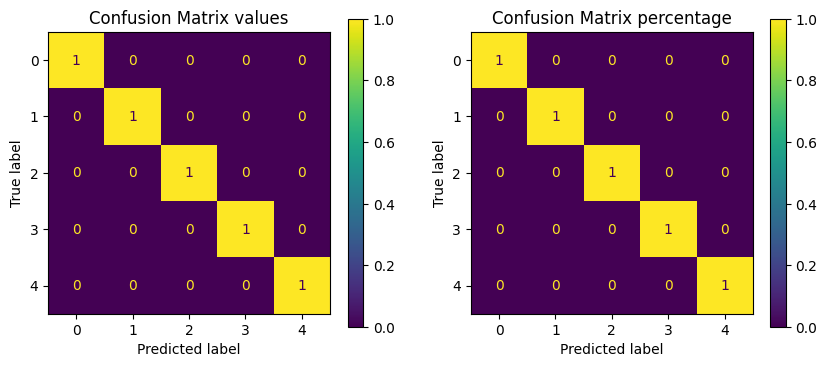

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

test_pred_labels = np.argmax(test_pred, axis=1)

true_test_pred_labels = test.labels

# Plot Confusion Matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(true_test_pred_labels, test_pred_labels, ax=ax0)
ax0.set_title("Confusion Matrix values")

ConfusionMatrixDisplay.from_predictions(true_test_pred_labels, test_pred_labels, normalize="true", ax=ax1)
ax1.set_title("Confusion Matrix percentage")
 
plt.show()

lel's save the model to json using tensorflowjs

## Save the model to json using tensorflowjs

>use tfjs env

1. ``cd C:\Users\louis\OneDrive\Bureau\Project-MedAI``
2. cmd command: ``tensorflowjs_converter --input_format=keras  model.h5 tfjs_model_pytorch``

1. ``cd C:\Users\louis\OneDrive\Bureau\Project-MedAI``
2. cmd command: ``tensorflowjs_converter --input_format=keras  model.h5 tfjs_model_pytorchv2``